# Analysis of MITgcm llc4320 model output in the Tropical Pacific
### with focus on sea-surface height 

In [401]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

sys.path.insert(0, '../../')
import TropicalPacific_params as TPparams
import TropicalPacific_map as TPmap

from pyspec import spectrum as spec

In [402]:
grid_path = '../grid/'
dd = 5.

In [403]:
llc4320 = TPparams.LLC4320(grid_path=grid_path)
llc4320map = TPmap.map(lonmin = llc4320.xg.min()-dd,lonmax = llc4320.xg.max()+dd,
                       latmin = llc4320.yg.min()-dd,latmax = llc4320.yg.max()+dd)

# The region

The region of study is the Tropical South Pacific. The regional limits  roughtly match on the [animation](http://www-pord.ucsd.edu/~sgille/cryosat-2_animated_modes_mask-world.gif) that shows the Cryosat-SAR mode sampling (see magenta lines in the map below).

The llc4320 output spans roughly $4.5$ months starting in September 2011. The model data are available hourly.

In [75]:
xg_region = np.hstack([llc4320.xg[0,0],llc4320.xg[0,-1],
                          llc4320.xg[-1,-1],llc4320.xg[-1,0],
                          llc4320.xg[0,0]])

yg_region = np.hstack([llc4320.yg[0,0],llc4320.yg[0,-1],
                          llc4320.yg[-1,-1],llc4320.yg[-1,0],
                          llc4320.yg[0,0],])

xg_subregion = np.hstack([-125.,-105,-105,-125,-125])
yg_subregion = np.hstack([-25.,-25,-5,-5,-25])

xg_region, yg_region = llc4320map.m(xg_region,yg_region)
xg_subregion, yg_subregion = llc4320map.m(xg_subregion,yg_subregion)

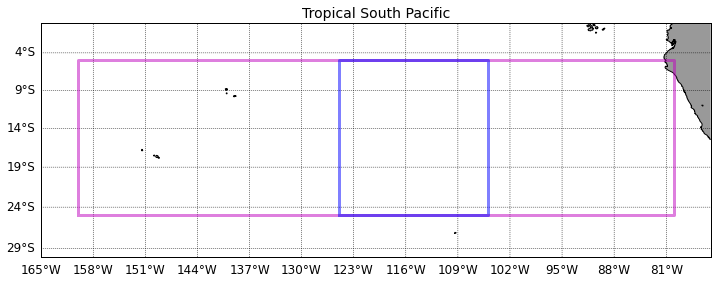

In [77]:
fig = plt.figure(facecolor='w', figsize=(12.,8.5))

llc4320map.m.fillcontinents(color='.60',lake_color='none')
llc4320map.draw_par_mer()
llc4320map.m.drawcoastlines()

llc4320map.m.plot(xg_region,yg_region,'m',linewidth=3.,alpha=.5)
llc4320map.m.plot(xg_subregion,yg_subregion,'b',linewidth=3.,alpha=.5)

plt.title('Tropical South Pacific')

# SSH variance spectra

Before we look at wavenumber spectra, it is instructive to calculate the wavenumber-frequency spectrum. That is, we calculate the energy density as a function of zonal ($k$) and meridional ($l$) wavenumber and frequency ($\omega$). This is a relatively costly calculation and it is done on *Pleaides*, the NASA high-end analysis supercomputer.

The analysis is performed in a $2200 \times 2220$ km subregion (see blue lines in the map above). To increase statistical significance, we chop the timeseries in four $34$-day segments, and average the spectral estimates.  The time series is too short to provide good estimates at low-frequency. The coarser resolution llc3260 may be help us better  explore low wavenumbers/low-frequencies.

In [84]:
spec_wv_freq = np.load('eta_var_wavenumber_freq_spec.npz')

In [132]:
nl,nk,nomg = spec_wv_freq['Eeta'].shape
dl, dk, domg = spec_wv_freq['l'][nl/2+1],spec_wv_freq['k'][nk/2+1], spec_wv_freq['omg'][0]

0.00022552999549033115

## First, we integrate the  spectrum in $l$ to produce a zonal wavenumber-frequency  spectrum
This analysis suggest that the high-frequency SSH is dominated by quasi-linear waves (I believe these straight lines are inertia gravity, "Poincare-like" modes, and other modes). There appears to be some quantization. The energy is concertrated at tidal frequencies, particularly $M_2$ and its harmonics, and very long wavelengths. There is a slight asymmetry suggesting more energy is propagating westward.

<matplotlib.colorbar.Colorbar instance at 0x149f56680>

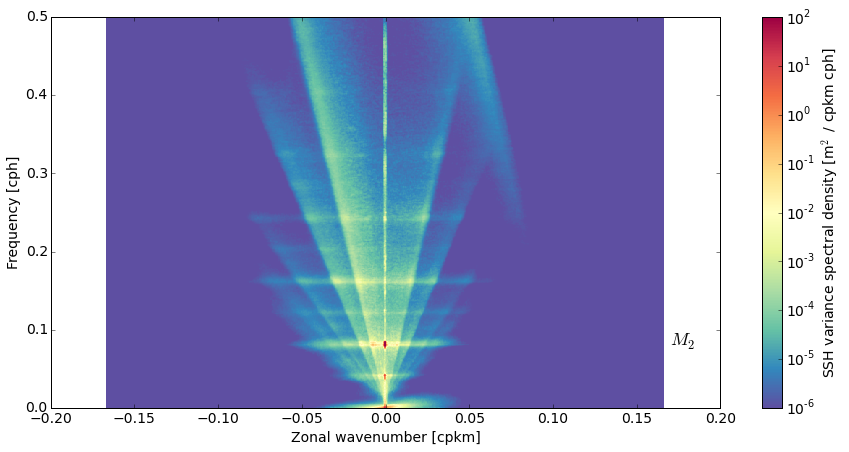

In [134]:
plt.figure(figsize=(15,7))
plt.pcolormesh(spec_wv_freq['k'],spec_wv_freq['omg'],
               spec_wv_freq['Eeta'].sum(axis=0).T*dl,norm = LogNorm())

plt.clim([1.e-6,1.e2])

#gg = np.sqrt(9.81*5000)
#plt.plot(spec_wv_freq['k'][nk/2:nk/2+200],gg*spec_wv_freq['k'][nk/2:nk/2+200],'k')
#plt.plot(spec_wv_freq['k'][nk/2-200:nk/2],-gg*spec_wv_freq['k'][nk/2-200:nk/2],'k')

plt.ylim(0.,0.5)

plt.xlabel('Zonal wavenumber [cpkm]')
plt.ylabel('Frequency [cph]')

plt.text(.17,1./12.4,r'$M_2$',fontsize=18)

plt.colorbar(label=r'SSH variance spectral density [m$^2$ / cpkm cph]')

## Similarly, we integrate the  spectrum in $k$ to produce a meridional wavenumber-frequency  spectrum

The picture here is very similar to that above, suggestion that the flow is relatively horizontally isotropic.

<matplotlib.colorbar.Colorbar instance at 0x152fb6c68>

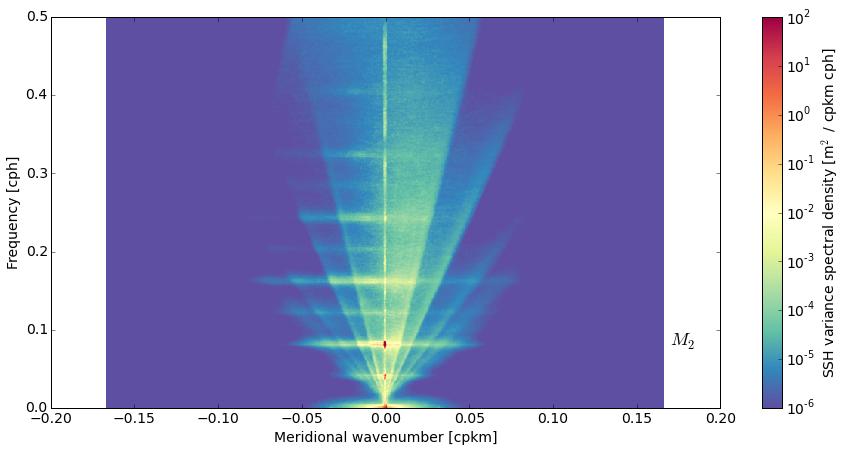

In [135]:
plt.figure(figsize=(15,7))
plt.pcolormesh(spec_wv_freq['l'],spec_wv_freq['omg'],
               spec_wv_freq['Eeta'].sum(axis=1).T*dk,norm = LogNorm())

plt.clim([1.e-6,1.e2])

plt.xlabel('Meridional wavenumber [cpkm]')
plt.ylabel('Frequency [cph]')

plt.text(.17,1./12.4,r'$M_2$',fontsize=18)

plt.colorbar(label=r'SSH variance spectral density [m$^2$ / cpkm cph]')

# Integrating both in $k$ and $l$ gives the frequency spectrum

Clearly the SSH variance is dominated by the $M_2$ tide ($T \approx 12.4$ h), with a secondary peak at a period twice as long as $M_2$ ($T \approx 24.8$ h). There are some small peaks at the harmonics of $M_2$. The subtidal flow is red, with roughly following a $\omega^{-2}$ power law.

In [434]:
#fd, Ed =  spec.avg_per_decade(spec_wv_freq['omg'][1:],spec_wv_freq['Eeta'].sum(axis=(0,1))[1:]*dk*dl,nbins = 20)

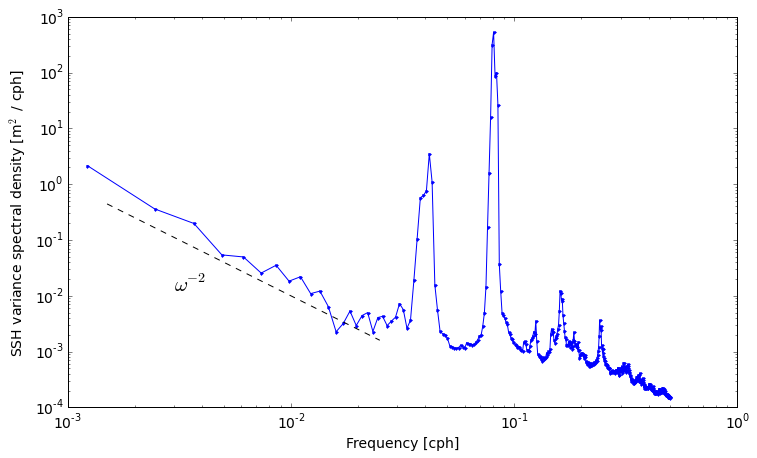

In [439]:
fi = np.array([1.5e-3,.25e-1])

plt.figure(figsize=(12,7))

plt.loglog(spec_wv_freq['omg'],spec_wv_freq['Eeta'].sum(axis=(0,1))*dk*dl,'.-')
#plt.loglog(fd,Ed,'r.-')

plt.loglog(fi,fi**-2/1.e6,'k--')
plt.text(3.e-3,1.2e-2,r'$\omega^{-2}$',fontsize=20)

plt.ylabel('SSH variance spectral density [m$^2$ / cph]')
plt.xlabel('Frequency [cph]')

# Wavenumber spectra

Now we plot the wavenumber spectrum of SSH variance. As a initial step, we calculate the 2D wavenumber spectrum of hourly and daily averaged model data. To estimate error bars, we assume a decorrelation time scale of about 10 days. This is likely a conservative estimate for the high-wavenumber variability.

The two-dimensional spectrum is fairly isotropic. The hourly fields show some quantization associated with these high-frequency modes.

Integrating the spectra azimuthally, we obtain the radial wavenumber spectrum of SSH variance. Clearly, most of the high-frequency variability projects onto  large scales ($> 500$ km), but there is also significant high-frequency variability at small scales. The spectrum is inconsistent with a single law. The spectrum of daily-averaged SSH is very shallow at large scales and relatively steep at small scales. If all this daily-averaged variability is due to geostrophic flows, then the KE spectrum would be flat at scales larger than $500$ km,  and about $k^{-3}$ at scales smaller than 30 km. An intermediate dependence on wavenumber exists at scales between $50$ and $200$ km.

In [441]:
spec_wv = np.load('eta_var_wavenumber.npz')

<matplotlib.colorbar.Colorbar instance at 0x1b8536488>

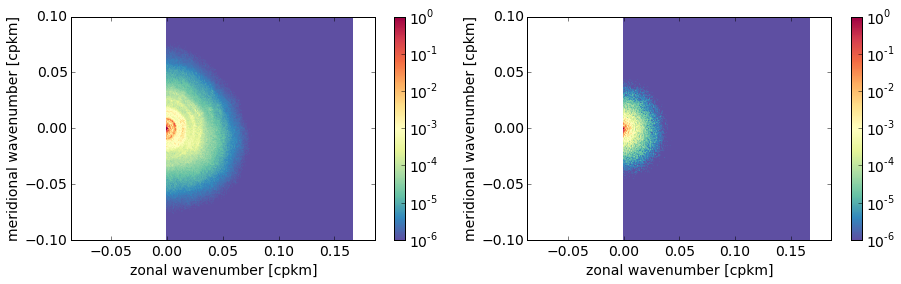

In [442]:
plt.figure(figsize=(15,4))

plt.subplot(121)
plt.pcolormesh(spec_wv['k'][nk/2:],spec_wv['l'],
               spec_wv['Eeta'],norm = LogNorm())

plt.clim([1.e-6,1.e0])

plt.colorbar()

plt.axis('equal')

plt.xlim(0,.1)
plt.ylim(-.1,.1)

plt.xlabel('zonal wavenumber [cpkm]')
plt.ylabel('meridional wavenumber [cpkm]')


plt.subplot(122)
plt.pcolormesh(spec_wv['k'][nk/2:],spec_wv['l'],
               spec_wv['Eetad'].squeeze(),norm = LogNorm())

plt.clim([1.e-6,1.e0])
plt.axis('equal')

plt.xlim(0,.1)
plt.ylim(-.1,.1)

plt.xlabel('zonal wavenumber [cpkm]')
plt.ylabel('meridional wavenumber [cpkm]')


plt.colorbar()

In [443]:
kr, Er = spec.calc_ispec(spec_wv['k'][nk/2:],spec_wv['l'],spec_wv['Eeta'])
_, Edr = spec.calc_ispec(spec_wv['k'][nk/2:],spec_wv['l'],spec_wv['Eetad'].squeeze())

In [392]:
sn  = 10*np.ones(Er.size)

In [393]:
Erl,Eru = spec.spec_error(Er, sn, ci=0.95)  
Edrl,Edru = spec.spec_error(Edr, sn, ci=0.95)  

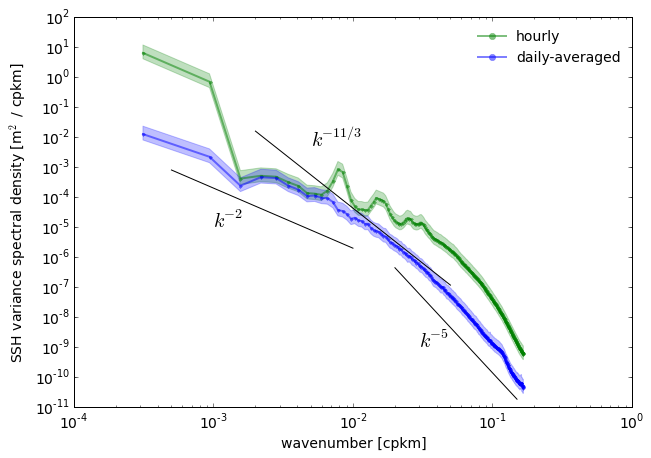

In [444]:
ki = np.array([5.e-4,1.e-2])
ki2 = np.array([2.e-2,1.5e-1])
ki3 = np.array([2.e-3,5.e-2])

plt.figure(figsize=(10,7))

plt.fill_between(kr,Erl,Eru, color='g', alpha=0.25)
plt.fill_between(kr,Edrl,Edru, color='b', alpha=0.25)
plt.loglog(kr,Er,'g.-',linewidth=2.,alpha=.5,label='hourly')
plt.loglog(kr,Edr,'b.-',linewidth=2.,alpha=.5,label='daily-averaged')

plt.loglog(ki,ki**-2./5.e9,'k')
plt.text(1.e-3,1.e-5,r'$k^{-2}$',fontsize=20)
plt.loglog(ki2,ki2**-5/7.e14,'k')
plt.text(3.e-2,1.e-9,r'$k^{-5}$',fontsize=20)

plt.loglog(ki3,ki3**(-11/3.)/5.e11,'k')
plt.text(5.e-3,.5e-2,r'$k^{-11/3}$',fontsize=20)

plt.xlabel('wavenumber [cpkm]')
plt.ylabel(r'SSH variance spectral density [m$^2$ / cpkm]')

plt.legend()